In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dense,Input,Lambda,Concatenate
from keras.models import Model
from keras.losses import categorical_crossentropy
import keras.backend as K
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

from scipy.stats import norm
from tqdm import tqdm as tqdm

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from src.utils import process_mnist,gen_trajectory,gen_sorted_isomap
from src.models import build_dense,CachedModel

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
class_ids = np.unique(y_train)
masks_train = [y_train==i for i in class_ids]
masks_test = [y_test==i for i in class_ids]

y_test_oh = to_categorical(y_test,num_classes=10)
y_train_oh = to_categorical(y_train,num_classes=10)

input_shape=(4*784,)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


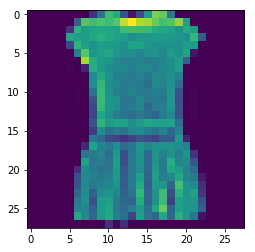

In [4]:
plt.imshow(x_train[3].reshape(28,28))

In [5]:
# Make dataset thats just a copy with random offsets
num_train = len(y_train)
num_test = len(y_test)

# pre-allocate shifted inputs
sx_train = np.empty((num_train,784*4))
sx_test = np.empty((num_test,784*4))

# pre-allocate list of dx,dy shifts for each image
delta_train = np.empty((num_train,2))
delta_test = np.empty((num_test,2))

def random_offset(X,scale=2):
    bg_size=(28*scale,28*scale)
    
    dx = int(np.random.randint(-10,10))+14
    dy = int(np.random.randint(-10,10))+14
    
    dx = max(dx,0)
    dx = min(dx,bg_size[0]-28)
    
    dy = max(dy,0)
    dy = min(dy,bg_size[0]-28)
#     print(dx,dy)
    new_im = np.zeros(bg_size)
    new_im[dx:dx+28,dy:dy+28] = letter
    
    return new_im,np.array([dx,dy])

print('making training data...')
for i in tqdm(np.arange(num_train)):
    letter = x_train[i].reshape(28,28)
    new_im,offsets = random_offset(letter,scale=2)
    sx_train[i] = new_im.reshape(1,4*784)
    delta_train[i] = offsets

print('making testing data...')
for i in tqdm(np.arange(num_test)):
    letter = x_test[i].reshape(28,28)
    new_im,offsets = random_offset(letter,scale=2)
    sx_test[i] = new_im.reshape(1,4*784)
    delta_test[i] = offsets

  0%|          | 0/60000 [00:00<?, ?it/s]

making training data...


 41%|████      | 4107/10000 [00:00<00:00, 41049.10it/s]

making testing data...


100%|██████████| 10000/10000 [00:00<00:00, 40529.34it/s]


2


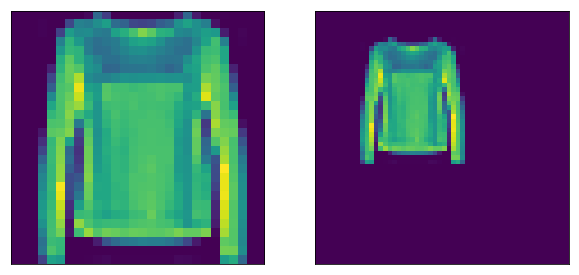

In [6]:
i = 250
print(y_train[masks_train[2]][i])
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(x_train[masks_train[2]][i].reshape(28,28))
axs[1].imshow(sx_train[masks_train[2]][i].reshape(28*2,28*2))

axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)

# fig.savefig('./shifted_mnist_3.png',dpi=300)

In [7]:
encoding_dims = [3000,1500]
z_dim = 2
y_dim = 3
inputs = Input(shape=input_shape)

# Brian Cheungs netowkr
encoded = build_dense(inputs,encoding_dims,activations='relu')

# encoded = build_dense(inputs,[512,encoding_dim],activations='relu')

In [20]:
z_mean = Dense(z_dim,name='z_mean')(encoded)
# z_log_sigma = Dense(latent_dim)(encoded)

def sampler(args):
    mean,log_stddev = args
    std_norm = K.random_normal(shape=(K.shape(mean)[0],latent_dim),mean=0,stddev=1)
    
    return mean + K.exp(log_stddev) * std_norm

# lat_vec = Lambda(sampler)([z_mean,z_log_sigma])

In [21]:
# y_hat_mean = Dense(y_dim,name='y_mean')(encoded)
# y_hat_sigma = Dense(y_dim,name='y_sigma')(encoded)
# y_hat = Lambda(sampler, name='y_hat')([y_hat_mean,y_hat_sigma])
y_hat = Dense(10,name='y_hat',activation='softmax')(encoded)

# Concatenate with One-hot identity vector
combo_vec = Concatenate()([z_mean,y_hat])

decoded_mean = build_dense(combo_vec,[encoding_dims[1],encoding_dims[0]]+[4*784],activations=['relu','relu','sigmoid'])
# decoded_mean = build_dense(combo_vec,[encoding_dim,512,784],activations=['relu','relu','sigmoid'])

In [22]:
from src.losses import *
from keras.metrics import categorical_accuracy

def acc(y_true,y_pred):
    return categorical_accuracy(y_true,y_hat)

def kl_loss_tot(y_true,y_pred):
    return kl_loss_z(y_true,y_pred)

def xentropy(y_true,y_pred):
    return 2*categorical_crossentropy(y_true,y_hat)

def recon_mse(y_true,y_pred):
    return K.mean(K.sum(K.square(y_pred-inputs),axis=-1),axis=0)

In [23]:
recon_loss = ReconstructionLoss(inputs=inputs,outputs=decoded_mean)
xcov = XCov(y_hat,z_mean,weight=1)
# kl_loss_z = KLDivergenceLoss(z_log_sigma,z_mean,weight=0.001,name='DKL_z')

In [35]:
vae = Model(inputs,decoded_mean)
def vae_loss(y_true,y_pred):
    total_loss = 0
    loss_fns = [
        K.sum(recon_loss(y_true,y_pred)),
        10*xcov(y_true,y_pred),
        K.sum(10*categorical_crossentropy(y_true,y_hat)),
#         K.sum(kl_loss_z(y_true,y_pred))/128,
#         K.sum(kl_loss_y(y_true,y_pred))
    ]
#     print(K.int_shape(xcov(y_true,y_pred)))
    for L in loss_fns:
        total_loss += L
        
    return total_loss
# vae.compile(loss=vae_loss,optimizer='rmsprop')
vae.compile(loss=vae_loss,optimizer='adadelta',metrics=[acc,xentropy])

In [36]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1500)         4501500     dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            3002        dense_2[0][0]                    
__________________________________________________________________________________________________
y_hat (Den

In [37]:
y_train_oh.shape

(60000, 10)

In [38]:
vae.fit(x=sx_train, y=y_train_oh,
        shuffle=True,
        epochs=50,
        batch_size=128,
       )

Epoch 1/50
60000/60000 [==============================] - 137s 2ms/step - loss: 14.0909 - acc: 0.6199 - xentropy: 1.9897
Epoch 2/50
60000/60000 [==============================] - 136s 2ms/step - loss: 9.2669 - acc: 0.7330 - xentropy: 1.3576
Epoch 3/50
60000/60000 [==============================] - 136s 2ms/step - loss: 8.0404 - acc: 0.7662 - xentropy: 1.1796
Epoch 4/50
60000/60000 [==============================] - 136s 2ms/step - loss: 7.3382 - acc: 0.7898 - xentropy: 1.0623
Epoch 5/50
60000/60000 [==============================] - 136s 2ms/step - loss: 6.7631 - acc: 0.8105 - xentropy: 0.9578
Epoch 6/50
60000/60000 [==============================] - 136s 2ms/step - loss: 6.3299 - acc: 0.8263 - xentropy: 0.8777
Epoch 7/50
60000/60000 [==============================] - 136s 2ms/step - loss: 5.9382 - acc: 0.8427 - xentropy: 0.8011
Epoch 8/50
 5248/60000 [=>............................] - ETA: 2:04 - loss: 5.3270 - acc: 0.8664 - xentropy: 0.6831

KeyboardInterrupt: 

In [39]:
encoder = Model(inputs,z_mean)
classifier = Model(inputs,y_hat)
decoder_inp = Input(shape=(12,))
# _generator_x = build_dense(decoder_inp,[encoding_dim,256,784],activations=['relu','relu','sigmoid'])
# generator = Model(decoder_inp,decoded_mean)
# print(generator.summary())
dec_layers = vae.layers[-3:]
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
outputs = dec_layers[2](_gen_x)
generator = Model(decoder_inp,outputs)

In [41]:
x_test_encoded = encoder.predict(sx_test,batch_size=128)
y_oh_enc = classifier.predict(sx_test,batch_size=128)

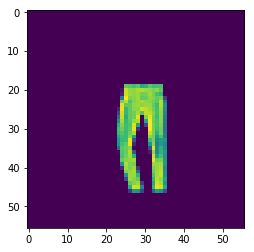

In [47]:
plt.imshow(sx_test[5].reshape(56,56))
# generator.predict()

(array([[  0.,   0.,   2.,   8.,   9.,   4.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  18.,  66.,  80.,  25.,   7.,   0.,   0.,   0.],
        [  0.,   1.,  50., 153., 225., 145.,  51.,   7.,   0.,   0.],
        [  0.,  20., 153., 340., 515., 385., 176.,  72.,  22.,   4.],
        [ 13.,  69., 206., 504., 952., 646., 281., 120.,  60.,  11.],
        [ 32.,  91., 231., 533., 774., 578., 251.,  78.,  20.,   3.],
        [  4.,  43., 114., 250., 427., 330., 152.,  32.,   8.,   0.],
        [  2.,   8.,  27.,  78., 141., 156.,  69.,  13.,   8.,   0.],
        [  0.,   0.,   4.,   4.,  30.,  54.,  32.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   6.,  12.,   4.,   0.,   0.,   0.]]),
 array([-4.265585  , -3.3845057 , -2.5034268 , -1.6223476 , -0.7412685 ,
         0.13981056,  1.0208896 ,  1.9019687 ,  2.783048  ,  3.6641269 ,
         4.545206  ], dtype=float32),
 array([-3.874526  , -3.0017934 , -2.129061  , -1.2563283 , -0.38359585,
         0.4891367 ,  1.3618692 ,  2.2346

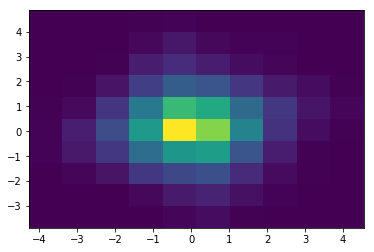

In [48]:
plt.hist2d(x_test_encoded[:,0],x_test_encoded[:,1])

In [49]:
cat_vec = np.concatenate([x_test_encoded[:5],y_oh_enc[:5]],axis=1)
cat_vec.shape

(5, 12)

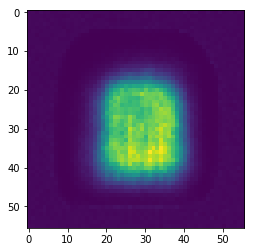

In [51]:
# x_test_encoded[2]
dec_test = generator.predict(cat_vec)
plt.imshow(dec_test[4].reshape(56,56))

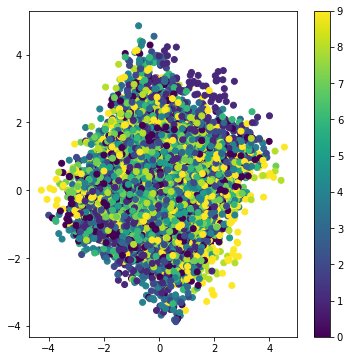

In [52]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [53]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9411000   
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              4501500   
_________________________________________________________________
z_mean (Dense)               (None, 2)                 3002      
Total params: 13,915,502
Trainable params: 13,915,502
Non-trainable params: 0
_________________________________________________________________


In [54]:
from datetime import date
print(date.today())
save_dir = '/home/elijahc/projects/vae/models/'+str(date.today())+'/'


2018-07-15


In [55]:
# vae.save(save_dir+'vae_3layer.h5',include_optimizer=False)
# encoder.save(save_dir+'enc.h5',include_optimizer=False)

In [56]:
def sweep_lat(z,y_class,sweep=0,hold=1,num_std=2):
    z_mean = z[:,sweep].mean()
    z_std = z[:,sweep].std()
    x0 = np.array([z_mean-(num_std*z_std),z[:,hold].mean()])
    x1 = np.array([z_mean+(num_std*z_std),z[:,hold].mean()])
    traj = gen_trajectory(np.concatenate([x0,y_class],axis=0),np.concatenate([x1,y_class],axis=0),delta=.1)
    return traj

In [57]:
# z0_mean = np.mean(x_test_encoded[:,0])
# z0_std = x_test_encoded[:,0].std()
# z1_mean = x_test_encoded[:,1].mean()
# z1_std = x_test_encoded[:,1].std()
# x0 = np.array([z0_mean-(2*z0_std),z1_mean])
# x1 = np.array([z0_mean+(2*z0_std),z1_mean])


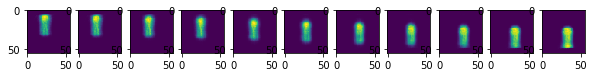

In [60]:
traj = sweep_lat(x_test_encoded,y_oh_enc[5])
dec_traj = K.get_value(generator(K.variable(traj)))
dec_traj = dec_traj.reshape(11,56,56)
fig, axs = plt.subplots(1,11,figsize=(10,10))
for i,ax in enumerate(axs):
    
    ax.imshow(dec_traj[i])

In [61]:
traj.shape

(11, 12)

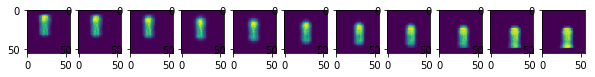

In [63]:
traj = sweep_lat(x_test_encoded,y_oh_enc[5],sweep=1,hold=0)
dec_traj = K.get_value(generator(K.variable(traj)))
dec_traj = dec_traj.reshape(11,56,56)
fig, axs = plt.subplots(1,11,figsize=(10,10))
for i,ax in enumerate(axs):
    
    ax.imshow(dec_traj[i])

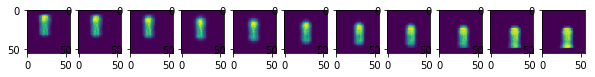

In [64]:
fig, axs = plt.subplots(1,11,figsize=(10,10))
for i,ax in enumerate(axs):
    
    ax.imshow(dec_traj[i])

(3, 12)


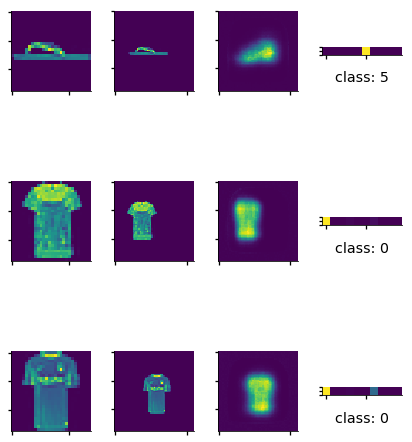

In [93]:
examples=3
sns.set_context('talk')
# sns.set_style('whitegrid')

# z0mean = z_mean_enc[:,0].mean()
# z1mean = z_mean_enc[:,1].mean()
# z0_sigma = z_mean_enc[:,0].std()
# z1_sigma = z_mean_enc[:,1].std()
# # z2_sigma = x_test_lat_enc[:,2].std()

fig,axs = plt.subplots(examples,4,figsize=(6,8))
choices = np.random.choice(np.arange(len(y_test)),examples)
# lat_vec_ = z_mean_enc[choices]
lat_vec_ = np.concatenate([x_test_encoded[choices],y_oh_enc[choices]],axis=1)
print(lat_vec_.shape)
dec_test = generator.predict(lat_vec_)

# print(x_test_encoded[choices])

for i,idx in enumerate(choices):
    rec_true_im = x_test[idx].reshape(28,28)
    in_im = sx_test[idx].reshape(28*2,28*2)
    dec_im = dec_test[i].reshape(28*2,28*2)
    
    axs[i,0].imshow(rec_true_im)
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticklabels([])
    
    axs[i,1].imshow(in_im)
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticklabels([])
    
    axs[i,2].imshow(dec_im)
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticklabels([])
#     axs[2,i].set_xlabel("class: {}".format(str(np.argmax(y_class_enc[idx]))))
    
    axs[i,3].imshow(y_oh_enc[idx].reshape(-1,1).T)
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticklabels([])
    axs[i,3].set_xlabel("class: {}".format(str(np.argmax(y_oh_enc[idx]))))
    
plt.tight_layout()
sns.despine(fig=fig)
# plt.imshow(dec_test[2].reshape(28,28).T)

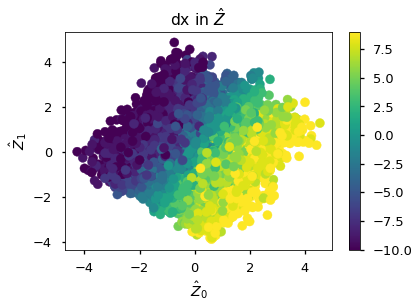

In [90]:
dxs = delta_test[:,0]
dys = delta_test[:,1]
sns.set_context('talk')
plt.scatter(x_test_encoded[:,0],x_test_encoded[:,1],c=dxs-14)
plt.colorbar()
plt.title(r"dx in $\hat{Z}$")
plt.xlabel(r"$\hat{Z}_0$")
plt.ylabel(r"$\hat{Z}_1$")
plt.savefig("../figures/shifted_fashion_mnist_dx.pdf",dpi=300)

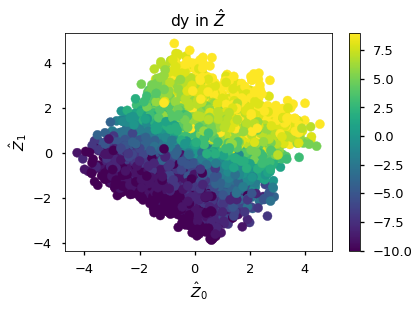

In [91]:
plt.scatter(x_test_encoded[:,0],x_test_encoded[:,1],c=dys-14)
plt.colorbar()
plt.title(r"dy in $\hat{Z}$")
plt.xlabel(r"$\hat{Z}_0$")
plt.ylabel(r"$\hat{Z}_1$")
plt.savefig("../figures/shifted_fashion_mnist_dy.pdf",dpi=300)

Text(0.5,1,'dxdy shift in $\\hat{Z}_0$')

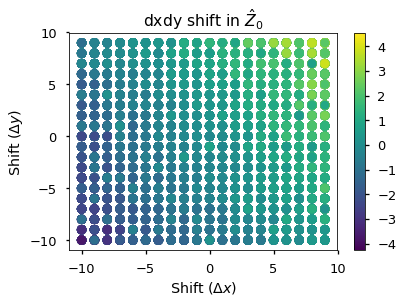

In [88]:
# fig,axs = plt.subplots(1,2,figsize=(12,5))
plt.scatter(dxs-14,dys-14,c=x_test_encoded[:,0])
# con = plt.contourf(dxs-14,dys-14,z_mean_enc[:,0])
# ax[1].scatter(dxs-14,dys-14,c=z_mean_enc[:,1])
# ax[0].set_xlabel('dx')
# ax[1].set_ylabel('dy')
plt.colorbar()
plt.xlabel(r"Shift ($\Delta x$)")
plt.ylabel(r"Shift ($\Delta y$)")
plt.title(r"dxdy shift in $\hat{Z}_0$")

In [ ]:
enc_32 = vae.layers[6]
enc_256 = vae.layers[7]

In [ ]:
encoder.trainable=False
x = enc_32(encoder.outputs[0])
y_class_oh = Dense(10,activation='softmax')(x)

In [ ]:
med = Model(inputs=inputs,outputs=y_class_oh)
med.layers[-2].trainable=False
for l in med.layers[1:4]:
    l.trainable=False
med.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
y_train_oh = to_categorical(y_train,num_classes=10)

In [ ]:
y_train_oh.shape

In [ ]:
med.summary()

In [ ]:
med.fit(x_train,y_train_oh,
        batch_size=128,
        epochs=25,
        validation_data=(x_test,to_categorical(y_test,num_classes=10))
       )

In [ ]:
x_g = generator.predict(x_test_encoded[:3])
y_test_im = x_g.reshape(3,28,28)

In [ ]:
x_test_im = x_test.reshape(10000,28,28)[:3]

fig,axs = plt.subplots(1,3)
for im,ax in zip(x_test_im,axs):
    ax.imshow(im)

In [ ]:
fig,axs = plt.subplots(1,3)
for im,ax in zip(y_test_im,axs):
    ax.imshow(im)

In [ ]:
med.evaluate(x_test,to_categorical(y_test,num_classes=10))